In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = 9, 9

import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error,r2_score, accuracy_score
from sklearn.metrics import roc_auc_score



import warnings;warnings.filterwarnings('ignore')

### <font color = 'brown'>Importing the datasets</font>

In [2]:
churn_data = pd.read_csv("files/churn_data.csv",index_col = 'customerID')
customer_data = pd.read_csv("files/customer_data.csv",index_col = 'customerID')
internet_data = pd.read_csv("files/internet_data.csv",index_col = 'customerID')

### <font color = 'brown'>Merging the datasets</font>
<font color = 'brown'>The "customerId" column is common in all datasets.  
We will merge all datasets into a single dataframe named "dataset" </font>

In [3]:
data1 = pd.merge(churn_data, customer_data, how='inner', on='customerID')
dataset = pd.merge(data1, internet_data, how='inner', on='customerID')

In [4]:
dataset.describe()

,tenure,MonthlyCharges,SeniorCitizen
count,7042.000000,7042.000000,7042.000000
mean,32.366373,64.755886,0.162170
std,24.557955,30.088238,0.368633
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,0.000000
50%,29.000000,70.350000,0.000000
75%,55.000000,89.850000,0.000000
max,72.000000,118.750000,1.000000


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7042 entries, 7590-VHVEG to 8361-LTMKD
Data columns (total 20 columns):
tenure              7042 non-null int64
PhoneService        7042 non-null object
Contract            7042 non-null object
PaperlessBilling    7042 non-null object
PaymentMethod       7042 non-null object
MonthlyCharges      7042 non-null float64
TotalCharges        7042 non-null object
Churn               7042 non-null object
gender              7042 non-null object
SeniorCitizen       7042 non-null int64
Partner             7042 non-null object
Dependents          7042 non-null object
MultipleLines       7042 non-null object
InternetService     7042 non-null object
OnlineSecurity      7042 non-null object
OnlineBackup        7042 non-null object
DeviceProtection    7042 non-null object
TechSupport         7042 non-null object
StreamingTV         7042 non-null object
StreamingMovies     7042 non-null object
dtypes: float64(1), int64(2), object(17)
memory usage: 1.1+ MB


The data type - 'object' for TotalCharges tells us there is something wrong with the values in this feature.

In [6]:
dataset.head()

,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,0,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,0,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [7]:
#Since the feature "TotalCharges" has a data type 'object' where as it should have been float.
#Function to check single space empty values in any columns in the dataset. 
#It gives the count of rows per columns, that have a single space(' ') as the value input in them.

def check_empty_values(x):
    for i in x.columns:
        #print([i,len(dataset[dataset[i]==' '])])
        if len(dataset[dataset[i]==' ']) > 0:
            print(i ,':',len(dataset[dataset[i]==' ']) )
check_empty_values(dataset)

#This function gives the columns and the number of records that have a single space as input

TotalCharges : 11


In [8]:
#to drop the invalid rows found above and convert the 'TotalCharges' datatype to float
dataset = dataset[dataset.TotalCharges != ' ']
dataset['TotalCharges'] = dataset['TotalCharges'].astype(float)

In [9]:
#This will only be used for exploratory data analysis

def tenure_category(a) :
    
    if a["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (a["tenure"] > 12) & (a["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (a["tenure"] > 24) & (a["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (a["tenure"] > 48) & (a["tenure"] <= 60) :
        return "Tenure_48-60"
    elif a["tenure"] > 60 :
        return "Tenure_gt_60"
dataset["tenure_group"] = dataset.apply(lambda a:tenure_category(a),
                                      axis = 1)

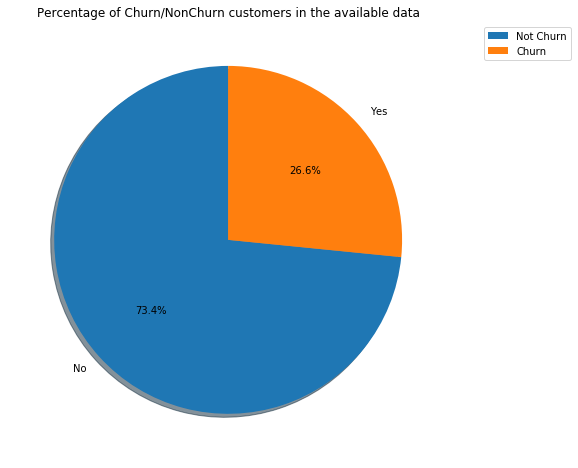

In [10]:
keys = dataset["Churn"].value_counts().keys().tolist()
values = dataset["Churn"].value_counts().values.tolist()
plt.rcParams['figure.figsize'] = 8,8
#fig= plt.figure(figsize=(7,7))
plt.pie(values, labels=keys, autopct='%1.1f%%', shadow=True, startangle=90)

plt.title("Percentage of Churn/NonChurn customers in the available data")
plt.legend(['Not Churn','Churn'],loc='upper right',bbox_to_anchor=(1.3,1))
#plt.tight_layout()



(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

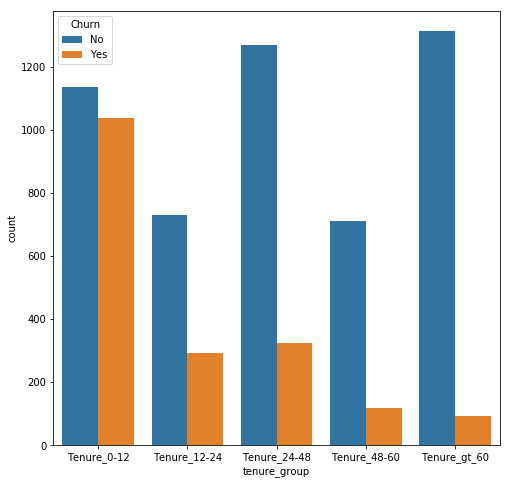

In [11]:
sns.countplot(data= dataset,x=dataset['tenure_group'],hue='Churn',
             order= ['Tenure_0-12','Tenure_12-24','Tenure_24-48','Tenure_48-60','Tenure_gt_60'])
plt.xticks(fontsize=10)

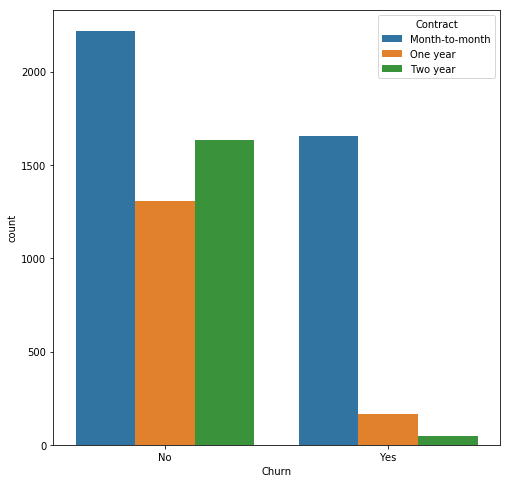

In [12]:
sns.countplot(x='Churn',hue='Contract',data=dataset)

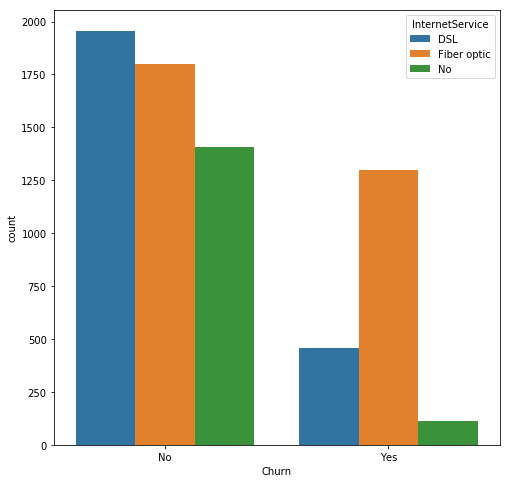

In [13]:
sns.countplot(x='Churn',hue='InternetService',data=dataset)

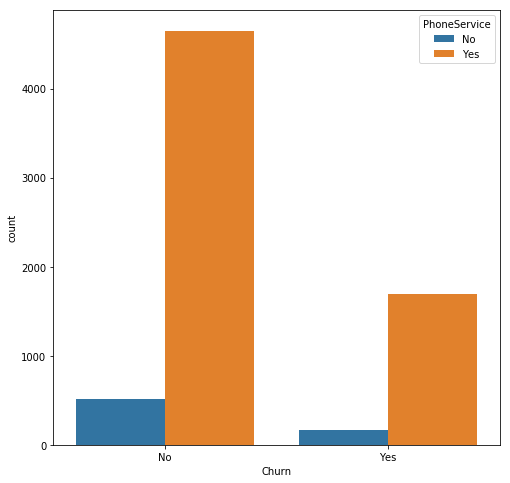

In [14]:
def plot_category(feature):
        sns.countplot(hue=feature,x='Churn',data=dataset)
plot_category('PhoneService')


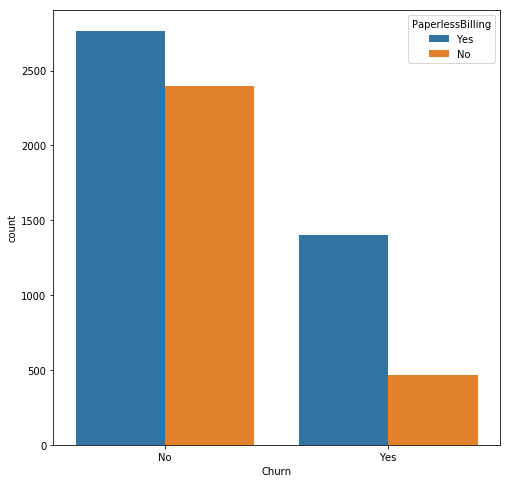

In [15]:
plot_category('PaperlessBilling')

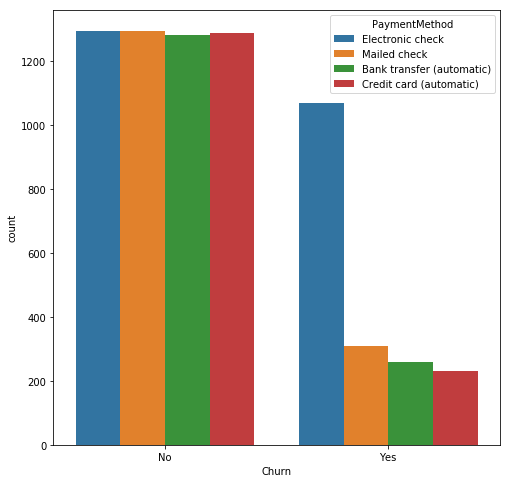

In [16]:
plot_category('PaymentMethod')

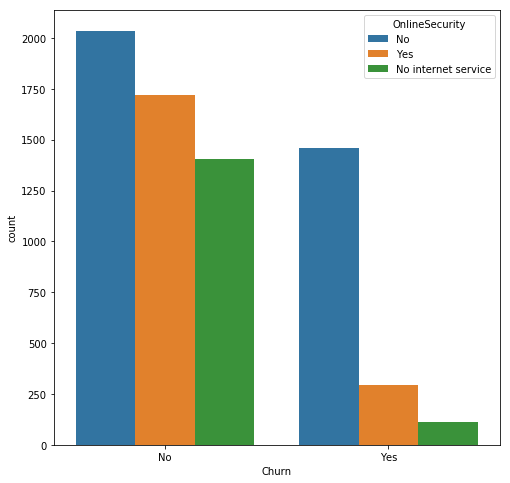

In [17]:
plot_category('OnlineSecurity') 

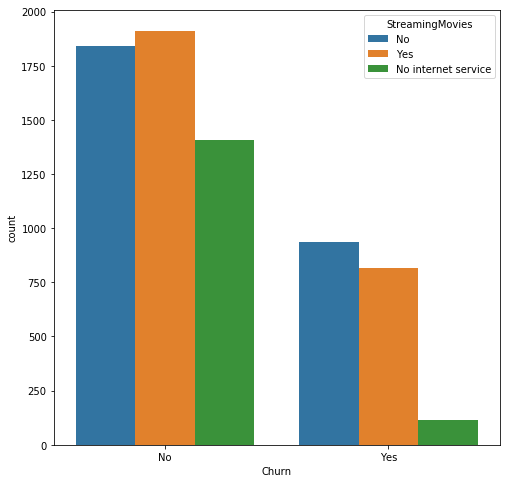

In [18]:
plot_category('StreamingMovies')

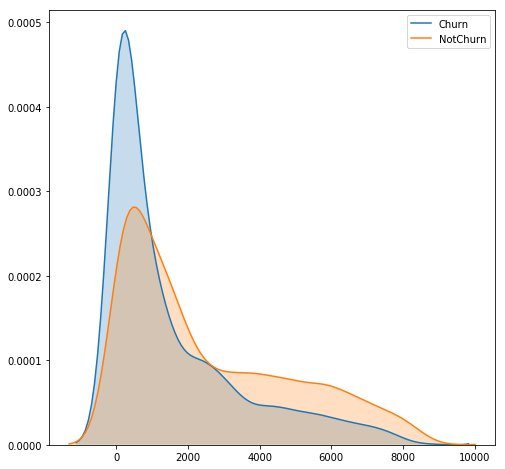

In [19]:
churn     = dataset[dataset["Churn"] == "Yes"]
not_churn = dataset[dataset["Churn"] == "No"]

sns.kdeplot(data=churn['TotalCharges'],shade=True)
sns.kdeplot(data=not_churn['TotalCharges'],shade=True)

plt.legend(['Churn','NotChurn'])


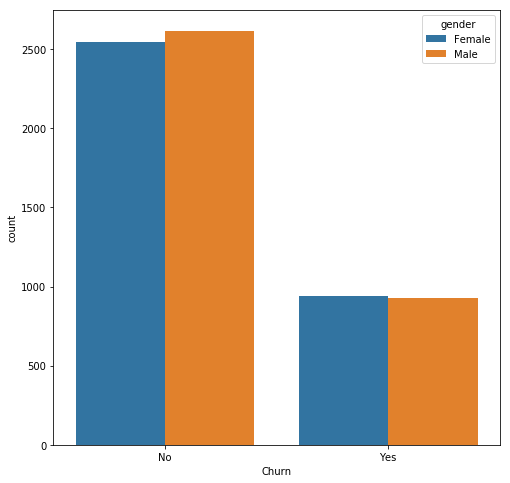

In [20]:
plot_category('gender')

### <font color = 'brown'>Observations:</font>
<font color = 'brown'>The below columns seems to influence whether a customer churns or not  
tenure, Contract(Month-to-month),Contract(Month-to-month), InternetService(FiberOptics), PaymentMethod(ElectronicCheck), OnlineSecurity(No), TotalCharges</font>

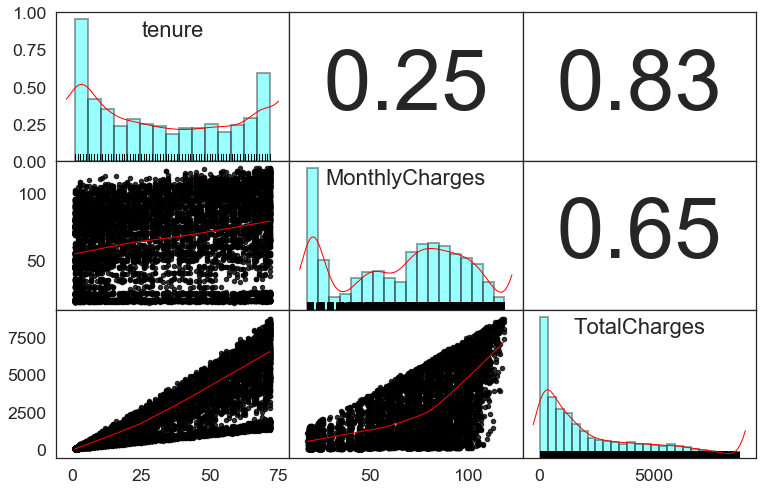

In [21]:
rel=dataset.filter(['tenure',  'MonthlyCharges', 'TotalCharges', 'Churn'],axis=1)

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = round(corr_r, 2)
    ax = plt.gca()
    font_size = 85
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)


sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(rel, aspect=1.5, diag_sharey=False, despine=False)
g.map_lower(sns.regplot, lowess=True, ci=False,
            line_kws={'color': 'red', 'lw': 1},
            scatter_kws={'color': 'black', 's': 20})
g.map_diag(sns.distplot, color='cyan',
           kde_kws={'color': 'red', 'cut': 0.7, 'lw': 1},
           hist_kws={'histtype': 'bar', 'lw': 2,
                     'edgecolor': 'k', 'facecolor':'cyan'})
g.map_diag(sns.rugplot, color='black')
g.map_upper(corrdot)
#g.map_upper(corrfunc)
g.fig.subplots_adjust(wspace=0, hspace=0)

# Remove axis labels
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

# Add titles to the diagonal axes/subplots
for ax, col in zip(np.diag(g.axes), rel.columns):
    ax.annotate(col,[.5, .95],  xycoords="axes fraction",
                ha='center', va='top', fontsize=22)

<font color = 'brown'>Tenure and totalcharges have strong correlation. It rings alarm that these two features are dependant. It might indicate only one of the features in the final model would be enough.</font>

In [22]:
#CATEGORY VARIABLES/FEATURES
columns = [ 'PhoneService', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'gender','Churn',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies']
for i in columns:
    print (i,':',dataset[i].unique())

PhoneService : ['No' 'Yes']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
gender : ['Female' 'Male']
Churn : ['No' 'Yes']
SeniorCitizen : [0 1]
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']


In [23]:
#Replacing "No Internet Service" with "No" for the following variables.
var2 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'] 
for i in var2:
    dataset[i] = dataset[i].replace('No internet service','No') 

In [24]:
#Lets convert these categorical columns into 1 and 0 binary values

var3 = ['PhoneService','PaperlessBilling','Churn','Partner',
       'Dependents','OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies']

def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

dataset[var3] = dataset[var3].apply(binary_map)

### <font color = 'brown'>We found this category_encoder library which saves a lot of work as compared to label encoding and one hot encoding because it keeps the feature names and their distinct values intact to be used a feature labels</font>

In [25]:
dataset = dataset.drop('tenure_group',axis=1)

ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
dataset = ohe.fit_transform(dataset)
dataset.shape

(7031, 30)

In [26]:
#To verify if the encoder worked as required, lets check distinct values of all features.

def unique_col_values(dataset):
    for i in dataset.columns:
        print (i,':',dataset[i].unique())
unique_col_values(dataset)


tenure : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService : [0 1]
Contract_Month-to-month : [1 0]
Contract_One year : [0 1]
Contract_Two year : [0 1]
PaperlessBilling : [1 0]
PaymentMethod_Electronic check : [1 0]
PaymentMethod_Mailed check : [0 1]
PaymentMethod_Bank transfer (automatic) : [0 1]
PaymentMethod_Credit card (automatic) : [0 1]
MonthlyCharges : [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges : [  29.85 1889.5   108.15 ... 7362.9   346.45  306.6 ]
Churn : [0 1]
gender_Female : [1 0]
gender_Male : [0 1]
SeniorCitizen : [0 1]
Partner : [1 0]
Dependents : [0 1]
MultipleLines_No phone service : [1 0]
MultipleLines_No : [0 1]
MultipleLines_Yes : [0 1]
InternetService_DSL : [1 0]
InternetService_Fiber optic : [0 1]
InternetService_No : [0 1]
OnlineSecurity : [0 1]
OnlineBackup : [1 0]
DeviceP

In [27]:
#Scaling the TotalCharges and MonthlyCharges

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
dataset1 = dataset
dataset1['TotalCharges'] = min_max_scaler.fit_transform(dataset1[['TotalCharges']])
dataset1['MonthlyCharges'] = min_max_scaler.fit_transform(dataset1[['MonthlyCharges']])

### <font color = 'brown'>Using Logistic Regression</font>

In [28]:
X = dataset1.drop(['Churn'],axis=1) # Features
y = dataset1.Churn # Target variable

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

from sklearn.linear_model import LogisticRegression
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
# fit the model with data
logreg.fit(X_train,y_train)
#
y_pred=logreg.predict(X_test)


In [29]:
# Evaluate the model
#score=logreg.score(X_test, y_test)
print("test accuracy:", logreg.score(X_test,y_test))
print("train accuracy:", logreg.score(X_train,y_train))
print("AUC Score:",roc_auc_score(y_test,y_pred))

test accuracy: 0.8122866894197952
train accuracy: 0.8035274037549782
AUC Score: 0.7292019851252324


<font color = 'brown'>The accuracy of logistic regression is 81.23%. </font>

Text(0.5, 25.5, 'Predicted label')

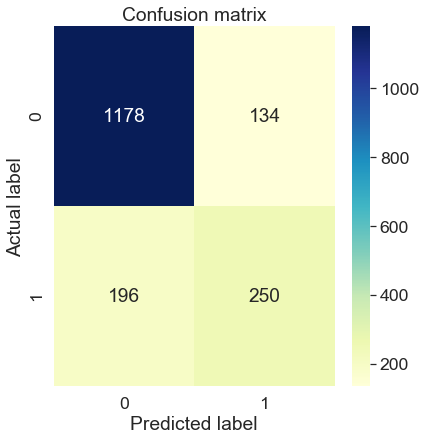

In [30]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
#visualize confusion_matrix
class_names=[0,1] # name  of classes
#fig, ax = plt.subplots()
fig= plt.figure(figsize=(6,6))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
#plt.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


Text(0.5, 1.0, 'Regression Variable Importances')

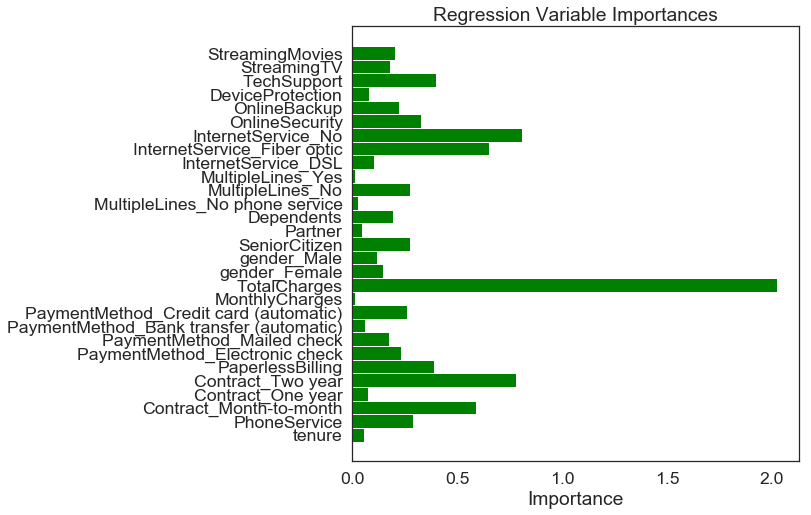

In [31]:
coef1=logreg.coef_.flatten()
importances1=abs(coef1)
plt.figure(figsize=(8,8))
x_values1 = list(range(len(importances1)))
# Make a horizontal chart
plt.barh(x_values1,importances1,height=1,color='green')
# Tick labels for x axis
plt.yticks(x_values1, X_train.columns, rotation='horizontal')
# Axis labels and title
plt.xlabel('Importance')
plt.title('Regression Variable Importances')

### <font color = 'brown'>Using RFE with Logistic Regression</font>

In [32]:

feature_cols = np.array(['tenure', 'PhoneService', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)', 'MonthlyCharges',
       'TotalCharges', 'gender_Female', 'gender_Male',
       'SeniorCitizen', 'Partner', 'Dependents',
       'MultipleLines_No phone service', 'MultipleLines_No',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies'])

estimator = LogisticRegression()
score_list =[]
high_score = 0
nof_list=np.arange(1,30)
for n in range(len(nof_list)):

    model = LogisticRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    supp = rfe.get_support()
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        optimum_features = feature_cols[supp]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score)) 
print("Selected Features:",optimum_features)


Optimum number of features: 26
Score with 26 features: 0.812287
Selected Features: ['tenure' 'PhoneService' 'Contract_Month-to-month' 'Contract_One year'
 'Contract_Two year' 'PaperlessBilling' 'PaymentMethod_Electronic check'
 'PaymentMethod_Mailed check' 'PaymentMethod_Bank transfer (automatic)'
 'PaymentMethod_Credit card (automatic)' 'MonthlyCharges' 'TotalCharges'
 'gender_Female' 'gender_Male' 'SeniorCitizen' 'Dependents'
 'MultipleLines_No' 'InternetService_DSL' 'InternetService_Fiber optic'
 'InternetService_No' 'OnlineSecurity' 'OnlineBackup' 'DeviceProtection'
 'TechSupport' 'StreamingTV' 'StreamingMovies']


### <font color = 'brown'>Using Neural Network</font>

In [33]:
from sklearn.neural_network import MLPClassifier
MLP=MLPClassifier(activation='logistic',max_iter=1500,alpha=0.001,hidden_layer_sizes=(50,50,50))
MLP.fit(X_train,y_train)
y_pred1 = MLP.predict(X_test)
print('MLP accuracy on test data is:', MLP.score(X_test,y_test))
print('MLP accuracy on train data is:', MLP.score(X_train,y_train))
print('AUC score:',roc_auc_score(y_test,y_pred1))

MLP accuracy on test data is: 0.8100113765642776
MLP accuracy on train data is: 0.8086478285605917
AUC score: 0.7284175735535382


### <font color = 'brown'>Using naive_bayes to build the model</font>

#### <font color = 'brown'>Change continious columns(tenure, MonthlyCharges and TotallCharges) into categorical data</font>

In [34]:
M_category=dataset['MonthlyCharges']<70
M_category = M_category.to_frame()
M_category.columns = ['MCharges']
T_category=dataset['tenure']<30
T_category = T_category.to_frame()
T_category.columns = ['TCharges']
Total_category=dataset['TotalCharges']<2200
Total_category = Total_category.to_frame()
Total_category.columns = ['ToCharges']

dataset_new=pd.concat([dataset,M_category,T_category, Total_category],axis=1)
dataset_new.head()

,tenure,PhoneService,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),...,InternetService_No,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MCharges,TCharges,ToCharges
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1,0,1,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,True,True,True
5575-GNVDE,34,1,0,1,0,0,0,1,0,0,...,0,1,0,1,0,0,0,True,False,True
3668-QPYBK,2,1,1,0,0,1,0,1,0,0,...,0,1,1,0,0,0,0,True,True,True
7795-CFOCW,45,0,0,1,0,0,0,0,1,0,...,0,1,0,1,1,0,0,True,False,True
9237-HQITU,2,1,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,True,True,True


In [35]:
feature_cols = ['PhoneService', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'gender_Female', 'gender_Male',
       'SeniorCitizen', 'Partner', 'Dependents',
       'MultipleLines_No phone service', 'MultipleLines_No',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MCharges', 'TCharges', 'ToCharges']

X1 = dataset_new[feature_cols] # Features
y1 = dataset_new.Churn
X1_train,X1_test,y1_train,y1_test=train_test_split(X1,y1,test_size=0.25,random_state=0)

#### <font color='brown'>Fit in MultinomialNB</font>

In [36]:
from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB()
mnb.fit(X1_train, y1_train)
pred1=mnb.predict(X1_test)
acc1=mnb.score(X1_test,y1_test)
print("Test Accuracy of MultinomialNB is:",acc1)
print('AUC score:',roc_auc_score(y_test,pred1))

Test Accuracy of MultinomialNB is: 0.7781569965870307
AUC score: 0.7314954063217762


<font color = 'brown'>The accuracy of Naive Bayes is 77.82%.</font>

Text(0.5, 43.5, 'Predicted label')

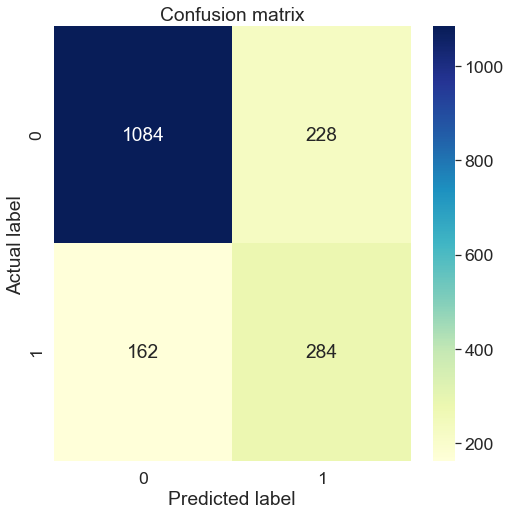

In [37]:
from sklearn.metrics import confusion_matrix
cnf_matrix=confusion_matrix(y1_test,pred1)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### <font color='brown'>Use DecisionTree to build the model</font>

In [38]:
from sklearn.tree import DecisionTreeClassifier
TREE= DecisionTreeClassifier(random_state=0,max_depth=4)
TREE.fit(X_train,y_train)
y_pred = TREE.predict(X_test)

In [39]:
print("Training data accuracy is :", TREE.score(X_train,y_train))
print("Test data accuracy is :", TREE.score(X_test,y_test))
print('AUC score:',roc_auc_score(y_test,y_pred))

Training data accuracy is : 0.7915797458752134
Test data accuracy is : 0.7935153583617748
AUC score: 0.7025661708410806


### <font color = 'brown'>Use DecisionTree for feature selection</font>

In [40]:
importances=TREE.feature_importances_
importances

array([0.06341711, 0.01032418, 0.55628425, 0.00521001, 0.        ,
       0.00425477, 0.01781193, 0.        , 0.        , 0.        ,
       0.02650783, 0.1359138 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01998227, 0.16029384, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

Text(0.5, 1.0, 'Decision Tree Variable Importances')

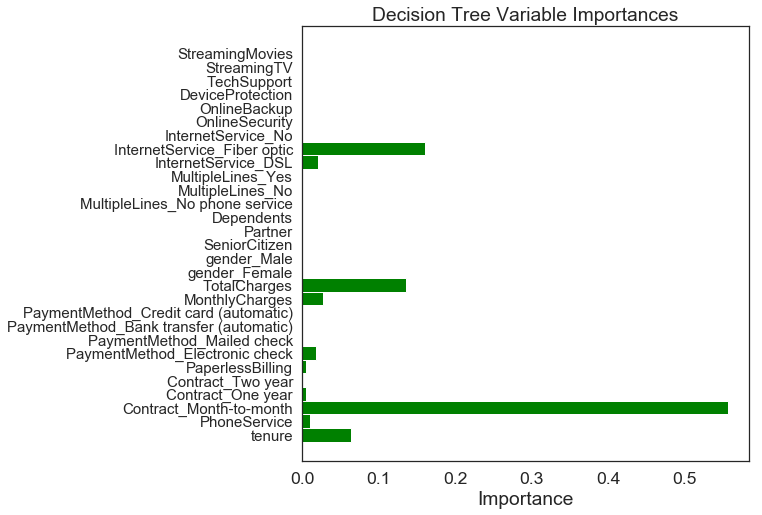

In [41]:
plt.figure(figsize=(8,8))
x_values = list(range(len(importances)))
# Make a horizontal chart
plt.barh(x_values,importances,height=1,color='green')
# Tick labels for x axis
plt.yticks(x_values,X_train.columns, rotation='horizontal',fontsize=15)
# Axis labels and title
plt.xlabel('Importance')
plt.title('Decision Tree Variable Importances')

### <font color='brown'>Using KNN with HYPER PARAMETER TUNING</font>

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score

#making the instance
model = KNeighborsClassifier(n_jobs=-1)

#Hyper Parameters Set
params = {'n_neighbors':[5,6,7,8,9,10],
          'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'n_jobs':[-1]}

#Generating and fitting the model with hyper-parameters
model1 = GridSearchCV(model, param_grid=params, n_jobs=1)
model1.fit(X_train,y_train)

#The best hyper parameters set
print("Best Hyper Parameters:\n",model1.best_params_)

#Prediction
prediction=model1.predict(X_test)

Best Hyper Parameters:
 {'algorithm': 'ball_tree', 'leaf_size': 5, 'n_jobs': -1, 'n_neighbors': 10, 'weights': 'uniform'}


In [43]:
#pd.DataFrame(model1.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
print ("Score on test data:",model1.score(X_test,y_test))
print('AUC score:',roc_auc_score(y_test,prediction))

Score on test data: 0.7940841865756542
AUC score: 0.6888876736300996


### <font color='brown'> Comparing Different Model Scores and AUC Scores</font>

In [44]:
A={'Models':['Logistic Regression','KNN','NaiveBayes','NeuralNetwork','DecisionTree'],
   'Score':[0.8122,0.7940,0.7804,0.8094,0.7935],
  'AUC_Scores':[0.7292,0.6888,0.7314,0.6943,0.7025]}
compare=pd.DataFrame(data=A)
compare.dtypes

Models         object
Score         float64
AUC_Scores    float64
dtype: object

In [45]:
new_data = pd.melt(compare,id_vars='Models', var_name='EvaluationMethod', value_name='Scores')
new_data

,Models,EvaluationMethod,Scores
0,Logistic Regression,Score,0.8122
1,KNN,Score,0.7940
2,NaiveBayes,Score,0.7804
3,NeuralNetwork,Score,0.8094
4,DecisionTree,Score,0.7935
5,Logistic Regression,AUC_Scores,0.7292
6,KNN,AUC_Scores,0.6888
7,NaiveBayes,AUC_Scores,0.7314
8,NeuralNetwork,AUC_Scores,0.6943
9,DecisionTree,AUC_Scores,0.7025


Text(0, 0.5, 'Scores')

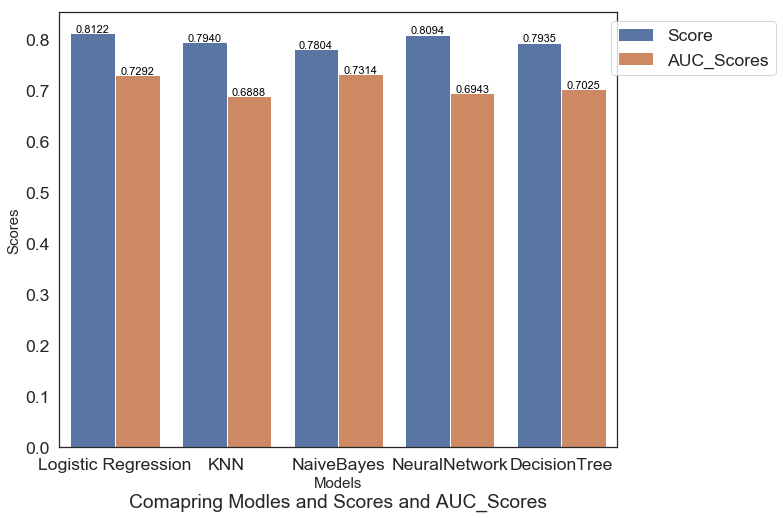

In [46]:
plt.figure(figsize=(10,8))
ax = sns.barplot(x ='Models',y = 'Scores',hue='EvaluationMethod',data= new_data)
plt.legend(bbox_to_anchor=(1.3,1))
plt.title("Comapring Modles and Scores and AUC_Scores",y=-.15)
for p in ax.patches:
             ax.annotate("%.4f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 4),
                 textcoords='offset points')
plt.xlabel('Models',fontsize=15)
plt.ylabel('Scores',fontsize=15)

### <font color = 'brown'>Summary:</font>
<font color = 'brown'>All the models we've used have good accuracy(>70%) and similar AUC(between 68-73%). 
    Both of feature selection methods showed Contract, TotalCharges and InternetService are the most important features.
</font>